# Word Vectors from Scratch with Dummy and Small Corpus

## Packages

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random

from collections import deque
import matplotlib.pyplot as plt

import json

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/eno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/eno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Importing our corpus and preprocessing

In [4]:
# Example usage
file_path = 'small_corpus.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()

In [5]:
def extract_unique_words(text):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Count the number of words and unique words
    print("# of words in the text: ", len(words))

    unique_words = sorted(set(words))
    print("# of unqiue words in the text: ", len(unique_words))

    return unique_words

In [6]:
unique_words = extract_unique_words(text)

# of words in the text:  210000
# of unqiue words in the text:  20


In [7]:
def generate_cbows(text, window_size):
    # Lowercase and tokenize the text
    text = text.lower()
    words = word_tokenize(text)

    # Remove punctuation
    words = [word for word in words if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Create CBOW pairs with a given window size
    cbows = []
    for i, target_word in enumerate(words):
        context_words = words[max(0, i - window_size):i] + words[i + 1:i + window_size + 1]
        if len(context_words) == window_size * 2:
            cbows.append((context_words, target_word))
    return cbows

In [8]:
# Create cbows
cbows = generate_cbows(text, window_size=3)

# Display the results
for context_words, target_word in cbows[:3]:
    print(f'Context Words: {context_words}, Target Word: {target_word}')

Context Words: ['pet', 'house', 'dog', 'play', 'animal', 'sleep'], Target Word: cat
Context Words: ['house', 'dog', 'cat', 'animal', 'sleep', 'pet'], Target Word: play
Context Words: ['dog', 'cat', 'play', 'sleep', 'pet', 'animal'], Target Word: animal


In [9]:
len(cbows)

209994

In [9]:
def one_hot_encoding(word, unique_words):
    encoding = [1 if word == w else 0 for w in unique_words]
    return torch.tensor(encoding, dtype=torch.float32)

In [10]:
# Create one-hot encodings for each word
one_hot_encodings = {word: one_hot_encoding(word, unique_words) for word in unique_words}
one_hot_encodings['king']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0.])

In [11]:
# Convert CBOW pairs to vector pairs
cbow_vector_pairs = [([one_hot_encodings[word] for word in context_words], one_hot_encodings[target_word]) for context_words, target_word in cbows]

In [12]:
cbow_vector_pairs[0][0] # contains the 6 context word one-hot encoded vectors

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]),
 tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1.])]

In [13]:
cbow_vector_pairs[0][1] # contains the center word as one-hot encoded vector

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [14]:
# Sum the context vectors to get a single context vector
cbow_vector_pairs = [(torch.sum(torch.stack(context_vectors), dim=0), target_vector) for context_vectors, target_vector in cbow_vector_pairs]

In [15]:
cbow_vector_pairs[0]

(tensor([1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 1.]),
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]))

## Converting the dataset to PyTorch Dataset

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = [item[0] for item in data]
        self.outputs = [item[1] for item in data]

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        output_sample = self.outputs[idx]
        return input_sample, output_sample

In [17]:
# Shuffle pairs before training
cbow_vector_pairs = random.sample(cbow_vector_pairs, len(cbow_vector_pairs))

# Train and Val split
split_index = int(len(cbow_vector_pairs) * 0.90)

# Split the data into training and test sets
train_dataset = CustomDataset(cbow_vector_pairs[:split_index])
test_dataset = CustomDataset(cbow_vector_pairs[split_index:])

# Set batch size
batch_size = 64  # You can adjust this based on your requirements

# Create DataLoader for training and test sets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Naive Word2Vec Model

In [90]:
class NaiveWord2Vec(nn.Module):

    def __init__(self, VOCAB_SIZE, VECTOR_DIM) -> None:
        super().__init__()

        self.vocab_size = VOCAB_SIZE
        self.vector_dim = VECTOR_DIM
        self.W1 = nn.Parameter(data=torch.randn(self.vocab_size, self.vector_dim), requires_grad=True) # Word Vectors
        self.W2 = nn.Parameter(data=torch.randn(self.vector_dim, self.vocab_size), requires_grad=True)

    def forward(self, X) -> torch.tensor:
        X = X @ self.W1
        X = X @ self.W2

        return X

In [91]:
VOCAB_SIZE = len(unique_words)
VECTOR_DIM = 2

## Training the model

In [92]:
model = NaiveWord2Vec(VOCAB_SIZE, VECTOR_DIM)

In [93]:
def train_model(model, train_dataloader, validation_dataloader, epochs, learning_rate, verbose=False):

    # Create the loss function
    loss_fn = nn.CrossEntropyLoss()
    # Create the optimizer object
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    # Log the loss values
    train_set_loss_log = []
    validation_set_loss_log = []

    for epoch in range(epochs):
        if verbose: print("Epoch: ", epoch)
        # Training mode on
        model.train()
        total_train_loss = 0.0
        num_train_batches = 0

        for inputs_batch, outputs_batch in train_dataloader:

            y_train_logits = model(inputs_batch)
            train_loss = loss_fn(y_train_logits, outputs_batch)
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            total_train_loss += train_loss.item()
            num_train_batches += 1            

        # Calculate average training loss for the epoch
        average_train_loss = total_train_loss / num_train_batches
        train_set_loss_log.append(average_train_loss)
        
        # Eval mode on
        model.eval()            
        total_validation_loss = 0.0
        num_validation_batches = 0

        with torch.inference_mode():
            for inputs_batch, outputs_batch in validation_dataloader:
                # Evaluate the validation loss
                y_val_logits = model(inputs_batch)
                validation_loss = loss_fn(y_val_logits, outputs_batch)

                total_validation_loss += validation_loss.item()
                num_validation_batches += 1
        
        # Calculate average validation loss for the epoch
        average_validation_loss = total_validation_loss / num_validation_batches
        validation_set_loss_log.append(average_validation_loss) 

        if verbose: print("Train Loss: ", average_train_loss, "|||", "Validation Loss: ", average_validation_loss)
        

    return model, train_set_loss_log, validation_set_loss_log

In [94]:
model, train_set_loss_log, validation_set_loss_log = train_model(model, train_dataloader, validation_dataloader, 
                                                                 epochs=3, learning_rate=0.01, verbose=True)

Epoch:  0
Train Loss:  1.983538118543541 ||| Validation Loss:  1.864598639105591
Epoch:  1
Train Loss:  1.8606215374810355 ||| Validation Loss:  1.8545821912382874
Epoch:  2
Train Loss:  1.852795512311428 ||| Validation Loss:  1.852743960441427


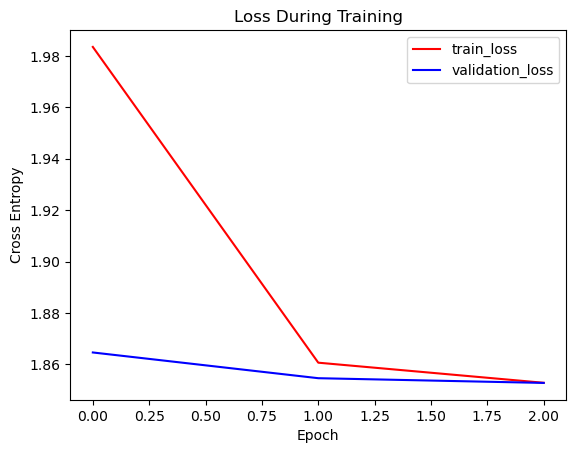

In [95]:
plt.plot(train_set_loss_log, color='red', label='train_loss')
plt.plot(validation_set_loss_log, color='blue', label='validation_loss')

plt.title("Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.legend()
plt.show()

In [96]:
# Word Vectors
params = list(model.parameters())
word_vectors = params[0].detach()

In [97]:
# Create a dictionary with the same order mapping
word_dict = {word: vector for word, vector in zip(unique_words, word_vectors)}

## Evaluating the Word Vectors

In [98]:
def cosine_similarity(v1, v2):
    return (v1 @ v2) / (torch.norm(v1) * torch.norm(v2))

def most_similar(word, word_dict, top_k=5):
    if word not in word_dict:
        raise ValueError(f"{word} not found in the word dictionary.")

    query_vector = word_dict[word]

    # Calculate cosine similarity with all other words in the dictionary
    similarities = {}
    for other_word, other_vector in word_dict.items():
        if other_word != word:
            similarity = cosine_similarity(query_vector, other_vector)
            similarities[other_word] = similarity

    # Sort the words by similarity in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Get the top-k most similar words
    top_similar_words = sorted_similarities[:top_k]

    return top_similar_words

In [99]:
word_dict

{'animal': tensor([-1.8037,  0.5236]),
 'boy': tensor([-0.2570, -0.6515]),
 'castle': tensor([0.1120, 0.2904]),
 'cat': tensor([-0.8275,  0.4206]),
 'country': tensor([0.2473, 0.0958]),
 'crown': tensor([3.2275, 0.1618]),
 'dog': tensor([-1.2545, -0.1008]),
 'empire': tensor([0.0877, 0.3232]),
 'family': tensor([-0.2446, -0.5552]),
 'father': tensor([-0.1075, -0.6936]),
 'girl': tensor([-0.1734, -0.5692]),
 'house': tensor([1.0459, 0.2697]),
 'king': tensor([1.3533, 2.6982]),
 'marriage': tensor([-1.1187, -5.5109]),
 'mother': tensor([-0.0292, -0.6051]),
 'pet': tensor([-1.0151,  0.0053]),
 'play': tensor([-1.2002, -0.1251]),
 'queen': tensor([0.2615, 0.0856]),
 'rule': tensor([0.1206, 0.1989]),
 'sleep': tensor([-0.7719, -0.0485])}

In [100]:
word_dict['dog']

tensor([-1.2545, -0.1008])

In [101]:
most_similar('dog', word_dict)

[('sleep', tensor(0.9998)),
 ('play', tensor(0.9997)),
 ('pet', tensor(0.9964)),
 ('animal', tensor(0.9349)),
 ('cat', tensor(0.8523))]

In [102]:
most_similar('father', word_dict)

[('marriage', tensor(0.9989)),
 ('mother', tensor(0.9944)),
 ('girl', tensor(0.9900)),
 ('boy', tensor(0.9755)),
 ('family', tensor(0.9661))]

In [103]:
most_similar('queen', word_dict)

[('country', tensor(0.9986)),
 ('house', tensor(0.9980)),
 ('crown', tensor(0.9648)),
 ('rule', tensor(0.7588)),
 ('king', tensor(0.7041))]

In [104]:
cosine_similarity(word_dict['father'], word_dict['mother'])

tensor(0.9944)

In [105]:
cosine_similarity(word_dict['family'], word_dict['empire'])

tensor(-0.9887)

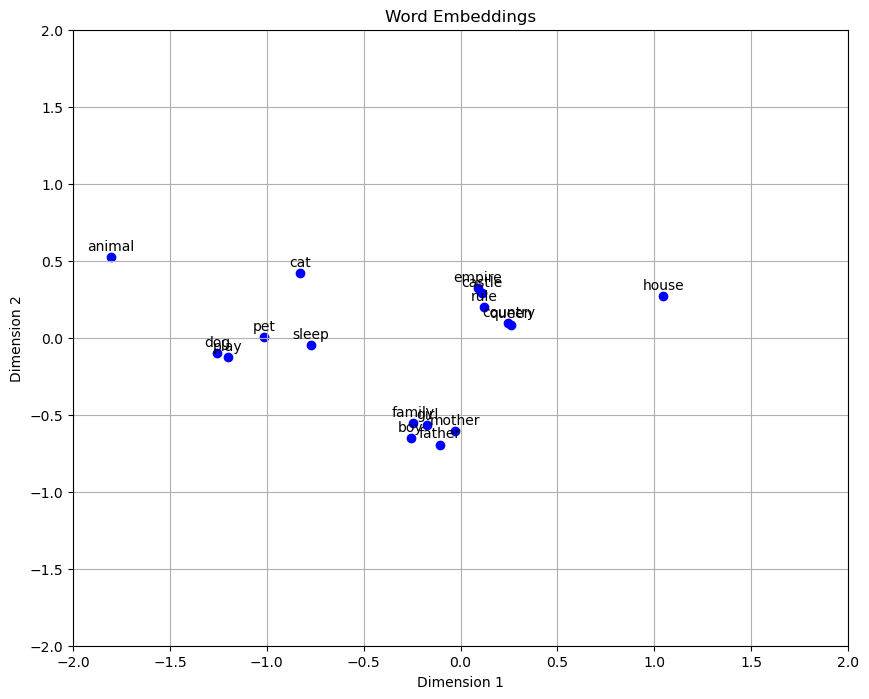

In [108]:
x_coords, y_coords = zip(*[word_dict[word].numpy() for word in list(word_dict.keys())])

plt.figure(figsize=(10, 8))
plt.scatter(x_coords, y_coords, marker='o', color='blue')

for i, word in enumerate(list(word_dict.keys())):
    plt.annotate(word, (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.title('Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

## Export Word Vectors

In [107]:
# Specify the file path where you want to save the JSON file
file_path = 'pretrained_word_vectors.json'

# Convert torch.Tensor objects to lists
word_vec_for_export = word_dict.copy()
for key, value in word_vec_for_export.items():
    if isinstance(value, torch.Tensor):
        word_vec_for_export[key] = value.tolist()

# Use json.dump to write the modified dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_vec_for_export, json_file, indent=2)

print(f'Dictionary has been exported to {file_path}')

Dictionary has been exported to pretrained_word_vectors.json
